<a href="https://colab.research.google.com/github/SimoneMonastero/Pink_Horizons/blob/main/CLASSIFIER/Classifier_FSST_3_days_SIMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CLASSIFICATION TASK

Questo codice concatena i due dataframe `FA` e `CO` in un nuovo dataframe chiamato `X`. L'argomento `ignore_index=True` assicura che il nuovo dataframe `X` abbia un indice continuo e non mantenga gli indici originali di `FA` e `CO` che potrebbero essere duplicati.

Average AUC:         0.7248 ± 0.0808
Average Sensitivity: 0.6233 ± 0.2384
Average Specificity: 0.7390 ± 0.1641


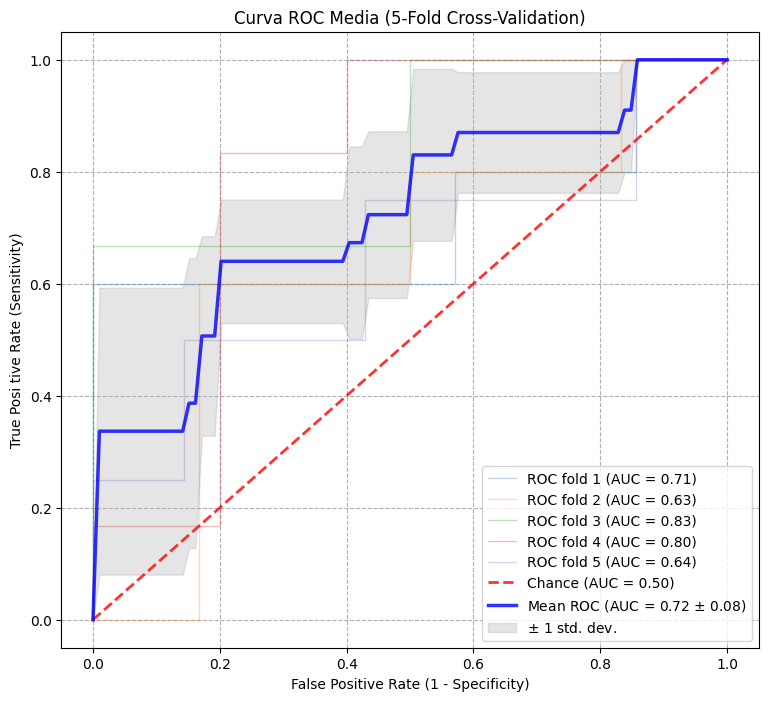

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import (
    roc_curve,
    auc,
    make_scorer,
    recall_score
)

SEED = 42
N_FOLDS = 5

X = pd.read_excel('/content/OUTPUTplusFSST.xlsx')
X = X.drop(columns=['#'])
X_features = X.drop('labels', axis=1)
Y = X['labels']

# Handle missing values by dropping rows with NaNs in X_features
X_features = X_features.dropna()
Y = Y[X_features.index] # Ensure Y aligns with the cleaned X_features

clf = LogisticRegression(max_iter=1000, class_weight='balanced')
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)


specificity_scorer = make_scorer(recall_score, pos_label=0)
scoring_metrics = {
    'auc': 'roc_auc',
    'sensitivity': 'recall',
    'specificity': specificity_scorer
}

score = cross_validate(
    clf,
    X=X_features,
    y=Y,
    cv=cv,
    return_train_score=True,
    return_estimator=True,
    scoring=scoring_metrics
)

mean_auc_cv = np.mean(score['test_auc'])
std_auc_cv = np.std(score['test_auc'])
avg_sensitivity = np.mean(score['test_sensitivity'])
std_sensitivity = np.std(score['test_sensitivity'])
avg_specificity = np.mean(score['test_specificity'])
std_specificity = np.std(score['test_specificity'])

print(f"Average AUC:         {mean_auc_cv:.4f} \u00B1 {std_auc_cv:.4f}")
print(f"Average Sensitivity: {avg_sensitivity:.4f} \u00B1 {std_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f} \u00B1 {std_specificity:.4f}")

tprs = []
aucs_plot = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(9, 8))

for i, (train_index, test_index) in enumerate(cv.split(X_features, Y)):

    fold_estimator = score['estimator'][i]
    X_test_fold = X_features.iloc[test_index]
    y_test_fold = Y.iloc[test_index]

    y_proba_fold = fold_estimator.predict_proba(X_test_fold)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_fold, y_proba_fold)

    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    roc_auc_fold = auc(fpr, tpr)
    aucs_plot.append(roc_auc_fold)

    ax.plot(fpr, tpr, lw=1, alpha=0.3,
            label=f'ROC fold {i+1} (AUC = {roc_auc_fold:.2f})')



ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance (AUC = 0.50)', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_cv, std_auc_cv),
        lw=2.5, alpha=.8)

# std
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')


ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Curva ROC Media ({N_FOLDS}-Fold Cross-Validation)",
    xlabel='False Positive Rate (1 - Specificity)',
    ylabel='True Posi tive Rate (Sensitivity)'
)
ax.legend(loc="lower right")
ax.grid(linestyle='--')

plt.show()